In [1]:
from scipy.constants import epsilon_0
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
from SimPEG.Utils import ndgrid
from ipywidgets import *

# Setup:

Sphere in a wholespace with a constant, uniform electric field

Parameters:

 - sigma_0 : conductivity of the background
 - sigma_1 : conductivity of the sphere

# Make a plot / a vector plot

x = np.linspace(0,1,50)
m = 1
b = 10
y = m*x + b

fig,ax = plt.subplots(1,2,figsize=(4,5))
ax[0].plot(x,y)

ax[1].plot(y,x)
http://www.3ptscience.com/app/DCresistivity

/Applications/Anaconda/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


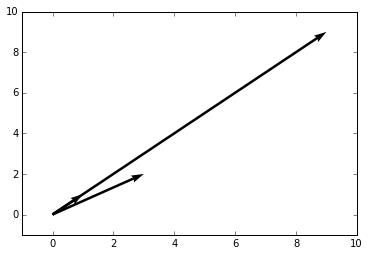

In [2]:
soa =np.array( [ [0,0,3,2], [0,0,1,1],[0,0,9,9]]) 
X,Y,U,V = zip(*soa)
plt.figure()
ax = plt.gca()
ax.quiver(X,Y,U,V,angles='xy',scale_units='xy',scale=1)
ax.set_xlim([-1,10])
ax.set_ylim([-1,10])
plt.draw()
plt.show()


# Integer/Float

In [3]:
print 1/3
print 1./3.

0
0.333333333333


# Parameters for the sphere Problem


In [9]:
sig0 = 10.        # conductivity of the wholespace
sig1 = 100.           # conductivity of the sphere
R    = 50.          # radius of the sphere
E0   = 1.           # inducing field strength
xr = np.linspace(-2.*R, 2.*R, 100)
yr = xr.copy()
xrr = xr[::10]
yrr = yr[::10]
zr = np.r_[0] # identical to saying `zr = np.array([0])`
XYZ = ndgrid(xr,yr,zr) #Half-Space Definition
# d    = 2           # mesh spacing

In [22]:
r  = lambda x,y,z: np.sqrt(x**2.+y**2.+z**2.)
sigf = lambda sig0,sig1: (sig1-sig0)/(sig1+2.*sig0)

In [23]:
#Define the conductivity for each point of the space
def get_Conductivity(XYZ,sig0,sig1,R):
    x,y,z = XYZ[:,0],XYZ[:,1],XYZ[:,2]
    r_view=r(x,y,z)
    
    int0= (r_view>R)
    int1= (r_view<=R)
    
    Sigma = np.zeros_like(x)
    
    Sigma[int0]=sig0
    Sigma[int1]=sig1
    
    return Sigma

# Potentials Computation

In [52]:
# assumes an x-oriented inducing field
# and that the sphere is at the origin
def get_Potential(XYZ,sig0,sig1,R,E0): 
    
    x,y,z = XYZ[:,0],XYZ[:,1],XYZ[:,2]
    
    sig_cur= sigf(sig0,sig1)
    
    r_cur = r(x,y,z)
    
    ind0 = (r_cur > R)
    ind1 = (r_cur <= R)
    
    assert (ind0 + ind1).all(), 'Some indicies not included'
    
    Vt = np.zeros_like(x)
    Vp = np.zeros_like(x)
    Vs = np.zeros_like(x)
    
    Vt[ind0] = -E0*x[ind0]*(1.-sig_cur*R**3./r_cur[ind0]**3.) # outside the sphere
    Vt[ind1] = -E0*x[ind1]*3.*sig0/(sig1+2.*sig0)
    
    Vp = - E0*x
    
    Vs = Vt - Vp
    
    return Vt,Vp,Vs

In [25]:
def get_Primary_Potential(XYZ,sig0,sig1,R,E0):
    x = XYZ[:,0]
    return - E0*x

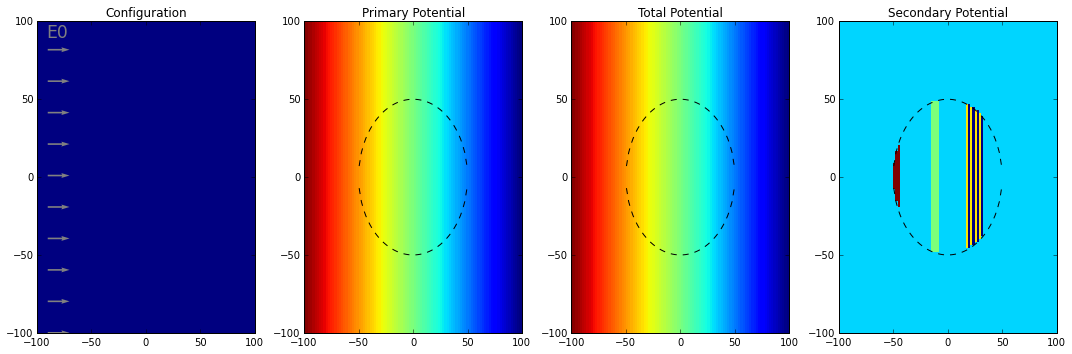

In [53]:
# Interactive tool to visualise the primary, secondary and total potentials

R_slider = FloatSlider(min=0., max =50., step=10.,value=50.)
S_slider = FloatSlider(min=1., max =100., step=1.,value=100.)

def plot_Potentials(R,sig1):
    Sigma = get_Conductivity(XYZ,sig0,sig1,R)
    Vt,Vp,Vs = get_Potential(XYZ,sig0,sig1,R,E0)
    #Vp = get_Primary_Potential(XYZ,sig0,sig1,R,E0)

    xcirc = xr[np.abs(xr) <= R]

    fig,ax = plt.subplots(1,4,figsize=(15,5))

    ax[0].pcolor(xr,yr,Sigma.reshape(xr.size, yr.size))
    ax[0].quiver(np.zeros_like(xrr)-90,yrr,E0,0,angles='xy',scale_units='xy',scale=0.05,color='gray')
    #ax[0].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[0].set_title('Configuration')
    ax[0].annotate('E0',(-90,90),xytext=(-90,90),fontsize='xx-large',color='gray')

    ax[1].pcolor(xr,yr,Vp.reshape(xr.size,yr.size))
    ax[1].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[1].set_title('Primary Potential')

    ax[2].pcolor(xr,yr,Vt.reshape(xr.size,yr.size))
    ax[2].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[2].set_title('Total Potential')

    ax[3].pcolor(xr,yr,Vs.reshape(xr.size,yr.size))
    ax[3].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[3].set_title('Secondary Potential')

    plt.tight_layout()
    
interact(plot_Potentials, R=R_slider, sig1=S_slider)

# Electric Field Computation

In [29]:
#Function that returns the primary and total electric fields

def get_ElectricField (XYZ,sig0,sig1,R,E0):
    
    x,y,z= XYZ[:,0], XYZ[:,1], XYZ[:,2]
    
    r_cur=r(x,y,z)
    
    ind0= (r_cur>R)
    ind1= (r_cur<=R)
    
    assert (ind0 + ind1).all(), 'Some indicies not included'
        
    Ep = np.zeros(shape=(len(x),3))
    Ep[:,0] = E0
    
    Et = np.zeros(shape=(len(x),3))
    
    Et[ind0,0] = E0 + E0*R**3./(r_cur[ind0]**5.)*sigf(sig0,sig1)*(2.*x[ind0]**2.-y[ind0]**2.-z[ind0]**2.);
    Et[ind0,1] = E0*R**3./(r_cur[ind0]**5.)*3.*x[ind0]*y[ind0]*sigf(sig0,sig1);
    Et[ind0,2] = E0*R**3./(r_cur[ind0]**5.)*3.*x[ind0]*z[ind0]*sigf(sig0,sig1);

    Et[ind1,0] = 3.*sig0/(sig1+2.*sig0)*E0;
    Et[ind1,1] = 0.;
    Et[ind1,2] = 0.;
    
    Es = Et - Ep
    
    return Et, Ep, Es


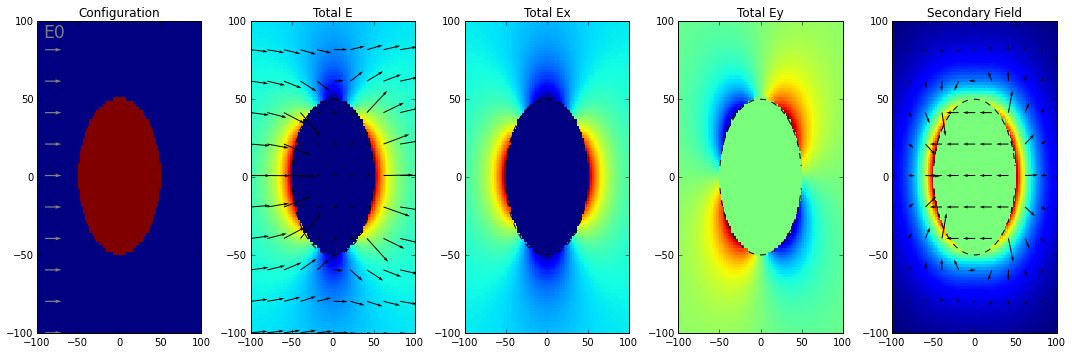

In [37]:
#Interavtice visualisation of the Electric Field

R_slider = FloatSlider(min=0., max =50., step=10., value=50.)
S_slider = FloatSlider(min=1., max =100., step=1.,value=100.)

def plot_ElectricField(R,sig1):
   
    Sigma = get_Conductivity(XYZ,sig0,sig1,R)
    Et, Ep, Es = get_ElectricField(XYZ,sig0,sig1,R,E0)
    
    xcirc = xr[np.abs(xr) <= R]
    
    ESXr = Es[:,0].reshape(xr.size, yr.size)
    ESYr = Es[:,1].reshape(xr.size, yr.size)
    ESZr = Es[:,2].reshape(xr.size, yr.size)
    ESX,ESY,ESZ=ESXr[::10,::10], ESYr[::10,::10], ESZr[::10,::10]
    
    EtXr = Et[:,0].reshape(xr.size, yr.size)
    EtYr = Et[:,1].reshape(xr.size, yr.size)
    EtZr = Et[:,2].reshape(xr.size, yr.size)
    EtX,EtY,EtZ=EtXr[::10,::10], EtYr[::10,::10], EtZr[::10,::10]
    
    xrr,yrr = xr[::10], yr[::10]
    
    fig,ax = plt.subplots(1,5,figsize=(15,5))

    ax[0].pcolor(xr,yr,Sigma.reshape(xr.size, yr.size))
    ax[0].quiver(np.zeros_like(xrr)-90,yrr,E0,0,angles='xy',scale_units='xy',scale=0.05,color='gray')
    #ax[0].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[0].set_title('Configuration')
    ax[0].annotate('E0',(-90,90),xytext=(-90,90),fontsize='xx-large',color='gray')
    
    ax[1].pcolor(xr,yr,np.sqrt(Et[:,0]**2+Et[:,1]**2).reshape(xr.size, yr.size))
    ax[1].quiver(xrr,yrr,EtX,EtY,angles='xy',scale_units='xy',scale=0.05)
    ax[1].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[1].set_title('Total E')

    ax[2].pcolor(xr,yr,Et[:,0].reshape(xr.size, yr.size))
    ax[2].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[2].set_title('Total Ex')

    ax[3].pcolor(xr,yr,Et[:,1].reshape(xr.size,yr.size))
    ax[3].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[3].set_title('Total Ey')

    ax[4].pcolor(xr,yr,np.sqrt(Es[:,1]**2+Es[:,0]**2).reshape(xr.size,yr.size))
    ax[4].quiver(xrr,yrr,ESX,ESY,angles='xy',scale_units='xy',scale=0.05)
    ax[4].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[4].set_title('Secondary Field')

    plt.tight_layout()
    
interact(plot_ElectricField, R=R_slider, sig1=S_slider)

# Current Density

Jx = @(x,y,z,sig1,sig2) ((r(x,y,z) > R).*sig1 + (r(x,y,z) <= R).*sig2).*(Ex(x,y,z,sig1,sig2));
Jy = @(x,y,z,sig1,sig2) ((r(x,y,z) > R).*sig1 + (r(x,y,z) <= R).*sig2).*(Ey(x,y,z,sig1,sig2));
Jz = @(x,y,z,sig1,sig2) ((r(x,y,z) > R).*sig1 + (r(x,y,z) <= R).*sig2).*(Ez(x,y,z,sig1,sig2));

jx = Jx(xg,y,zg,sig1,sig2);
jy = Jy(xg,y,zg,sig1,sig2);
jz = Jz(xg,y,zg,sig1,sig2);

In [38]:
#Computation of the current Density

def get_Current(XYZ,sig0,sig1,R,E0,Et,Ep,Es):
    
    x,y,z= XYZ[:,0], XYZ[:,1], XYZ[:,2]
    
    
    r_cur=r(x,y,z)
    
    ind0= (r_cur>R)
    ind1= (r_cur<=R)
    
    assert (ind0 + ind1).all(), 'Some indicies not included'
    
    Jt = np.zeros(shape=(len(x),3))
    J0 = np.zeros(shape=(len(x),3))
    Js = np.zeros(shape=(len(x),3))
    
    J0 = sig0*Ep
    
    Jt[ind0,:] = sig0*Et[ind0,:]   
    Jt[ind1,:] = sig1*Et[ind1,:]

    
    Js[ind0,:] = sig0*Es[ind0,:]
    Js[ind1,:] = sig1*Es[ind1,:]
    
    return Jt,J0,Js
    

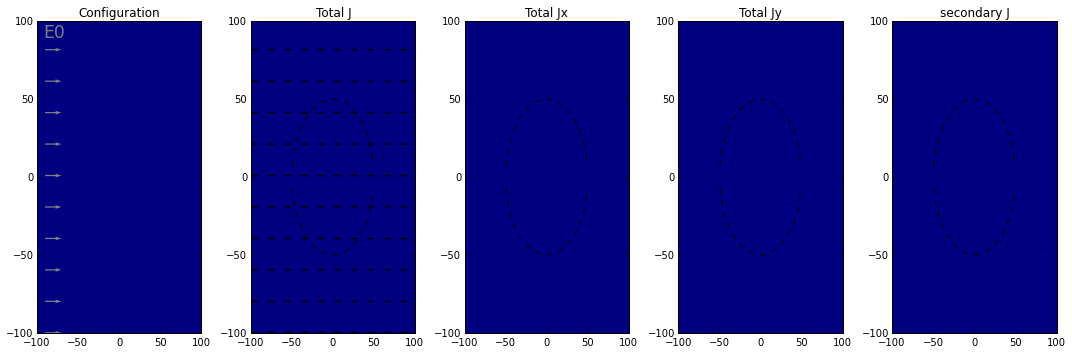

In [43]:
#Interavtice visualisation of the current density

R_slider = FloatSlider(min=0., max =50., step=10., value=50.)
S_slider = FloatSlider(min=1., max =100., step=1.,value=100.)

def plot_ElectricField(R,sig1):
   
    Sigma = get_Conductivity(XYZ,sig0,sig1,R)
    Et, Ep, Es = get_ElectricField(XYZ,sig0,sig1,R,E0)
    Jt,J0,Js = get_Current(XYZ,sig0,sig1,R,E0,Et,Ep,Es)
    
    xcirc = xr[np.abs(xr) <= R]
    
    JtXr = Jt[:,0].reshape(xr.size, yr.size)
    JtYr = Jt[:,1].reshape(xr.size, yr.size)
    JtZr = Jt[:,2].reshape(xr.size, yr.size)
    JtX,JtY,JtZ=JtXr[::10,::10], JtYr[::10,::10], JtZr[::10,::10]
    
    
    JsXr = Js[:,0].reshape(xr.size, yr.size)
    JsYr = Js[:,1].reshape(xr.size, yr.size)
    JsZr = Js[:,2].reshape(xr.size, yr.size)
    JsX,JsY,JsZ=JsXr[::10,::10], JsYr[::10,::10], JsZr[::10,::10]
    
    fig,ax = plt.subplots(1,5,figsize=(15,5))

    ax[0].pcolor(xr,yr,Sigma.reshape(xr.size, yr.size))
    ax[0].quiver(np.zeros_like(xrr)-90,yrr,E0,0,angles='xy',scale_units='xy',scale=0.05,color='gray')
    #ax[0].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[0].set_title('Configuration')
    ax[0].annotate('E0',(-90,90),xytext=(-90,90),fontsize='xx-large',color='gray')
    
    ax[1].pcolor(xr,yr,np.sqrt(Jt[:,0]**2+Jt[:,1]**2).reshape(xr.size, yr.size))
    ax[1].quiver(xrr,yrr,JtX,JtY,angles='xy',scale_units='xy',scale=1)
    ax[1].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[1].set_title('Total J')

    ax[2].pcolor(xr,yr,Jt[:,0].reshape(xr.size, yr.size))
    ax[2].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[2].set_title('Total Jx')

    ax[3].pcolor(xr,yr,Jt[:,1].reshape(xr.size,yr.size))
    ax[3].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[3].set_title('Total Jy')

    ax[4].pcolor(xr,yr,np.sqrt(Js[:,1]**2+Js[:,0]**2).reshape(xr.size,yr.size))
    ax[4].quiver(xrr,yrr,JsX,JsY,angles='xy',scale_units='xy',scale=1)
    ax[4].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[4].set_title('secondary J')
    

    plt.tight_layout()
    
interact(plot_ElectricField, R=R_slider, sig1=S_slider)